In [1]:
!pip install mesa

In [2]:
import enum
import random
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy import stats
import pandas as pd


import model 
import time
pd.options.display.max_rows = 150

Parameters:

- `N`: The number of agents in the model. The default is 10,000 agents.
- `width` and `height`: The size of the grid that the agents move around on. The default is 10x10.
- `ptrans`: The probability of transmission of the infection when a susceptible and infected agent come into contact. The default value is 0.002.
- `exposed_time`: controls the number of days that an infected agent is exposed before becoming infectious. When an agent first becomes infected, they are exposed to the disease but not yet able to transmit it to others. The exposed_time represents this incubation period.
- `incubation_time`: The time between infection and symptom onset drawn from a normal distribution with mean 5 and standard deviation 2. 
- `death_rate`: The probability that an infected agent dies each step. The default is 0.00904.
- `recovery_days` and `recovery_sd`: The mean and standard deviation of the normal distribution used to determine the recovery time of infected agents. In this case, the mean recovery time is 14 days and the standard deviation is 7 days.
- `vaccination_rate`: The proportion of susceptible individuals who get vaccinated each step. The default is 0.05.


**Note:** We start with Model 2 since Model 1 was the base model without an incubation period, which is not what’s required for this project.

## Defining Model Parameters 

In [3]:
# Define the number of simulation steps
k_steps = 100

# Create the initial model instance
my_model = model.GridInfectionModel(seed=101, N=10000, width=10, height=10, ptrans=0.002, 
                           progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                           recovery_sd=7, vaccination_rate=0.05, vaccination_delay=0, shots_needed=2)


# Sample Script for 1 Run

In [4]:
# Record the start time of the simulation
start_time = time.time()

# Run the simulation for 'k_steps' steps
for i in range(k_steps):
    my_model.step()
    
# Record the end time of the simulation
end_time = time.time()

# Print the time taken for the simulation
print(f"This model run of {k_steps} steps was completed in {round(end_time-start_time,1)} secs")

# Get data from the model
my_model_data = my_model.datacollector.get_model_vars_dataframe()
my_model_data

This model run of 100 steps was completed in 6.0 secs


,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9804,196,0,0,0
1,9755,245,0,0,0
2,9668,302,0,1,29
3,9572,362,2,1,63
4,9422,434,5,2,137
5,9231,536,13,2,218
6,9019,637,29,2,313
7,8786,755,38,4,417
8,8522,876,57,8,537
9,8224,1016,84,9,667


## Model 2 - with Incubation Period, NO vaccination delay

In [5]:
# Define the number of replications
num_reps = 50
model2_rep_data = []

# Run multiple replications of the model with different random seeds
for i in range(num_reps):
    model2_rep = model.GridInfectionModel(seed = random.seed(i), N=10000, width=10, height=10, ptrans=0.002,  
                              progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                              recovery_sd=7, vaccination_rate=0.05, vaccination_delay=0, shots_needed=2)

    for j in range(100):
        model2_rep.step()
    
    model2_rep_data.append(model2_rep.datacollector.get_model_vars_dataframe())

    print(f"Model 2 Replication {i+1} done")
    
# Record the end time of the simulation
end_time = time.time()

# Print the time taken for the simulation
print(f"This model run of {num_reps} replications was completed in {round(end_time-start_time,1)} secs")

Model 2 Replication 1 done
Model 2 Replication 2 done
Model 2 Replication 3 done
Model 2 Replication 4 done
Model 2 Replication 5 done
Model 2 Replication 6 done
Model 2 Replication 7 done
Model 2 Replication 8 done
Model 2 Replication 9 done
Model 2 Replication 10 done
Model 2 Replication 11 done
Model 2 Replication 12 done
Model 2 Replication 13 done
Model 2 Replication 14 done
Model 2 Replication 15 done
Model 2 Replication 16 done
Model 2 Replication 17 done
Model 2 Replication 18 done
Model 2 Replication 19 done
Model 2 Replication 20 done
Model 2 Replication 21 done
Model 2 Replication 22 done
Model 2 Replication 23 done
Model 2 Replication 24 done
Model 2 Replication 25 done
Model 2 Replication 26 done
Model 2 Replication 27 done
Model 2 Replication 28 done
Model 2 Replication 29 done
Model 2 Replication 30 done
Model 2 Replication 31 done
Model 2 Replication 32 done
Model 2 Replication 33 done
Model 2 Replication 34 done
Model 2 Replication 35 done
Model 2 Replication 36 done
M

# Calculating mean states across replicatons (Model 2)

In [6]:
# Convert the list to a numpy array
data_array2 = np.array(model2_rep_data)

# Calculate the mean across the first dimension
mean_data2 = data_array2.mean(axis=0)

mean_data2_df = pd.DataFrame(mean_data2, columns=[col for col in model2_rep_data[0].columns])
mean_data2_df

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9803.02,196.98,0.00,0.00,0.00
1,9759.18,240.72,0.06,0.04,0.00
2,9684.78,291.52,0.22,0.08,23.40
3,9576.80,352.60,0.94,0.28,69.38
4,9437.56,423.96,3.08,0.54,134.86
5,9271.16,505.70,8.12,1.16,213.86
6,9073.78,594.88,17.90,2.46,310.98
7,8845.84,697.54,32.54,4.58,419.50
8,8597.00,811.04,51.98,7.04,532.94
9,8323.38,937.90,75.22,10.14,653.36


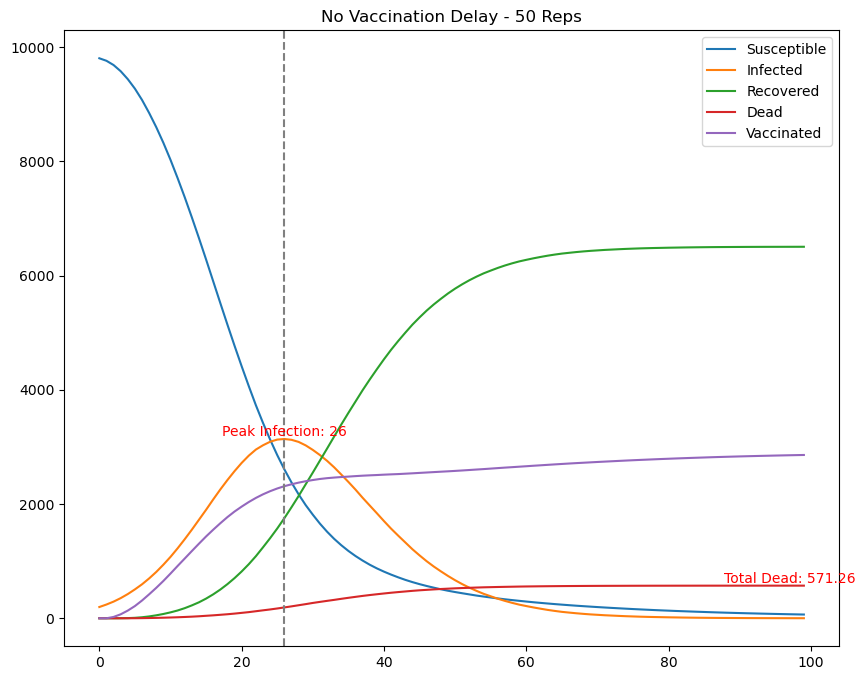

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(mean_data2_df['Total Susceptible'], label='Susceptible')
plt.plot(mean_data2_df['Total Infected'], label='Infected')
plt.plot(mean_data2_df['Total Recovered'], label='Recovered')
plt.plot(mean_data2_df['Total Dead'], label='Dead')
plt.plot(mean_data2_df['Total Vaccinated'], label='Vaccinated')
plt.axvline(mean_data2_df['Total Infected'].idxmax(), color='gray', linestyle='--')
plt.text(mean_data2_df['Total Infected'].idxmax(), mean_data2_df['Total Infected'].max(), f"Peak Infection: {mean_data2_df['Total Infected'].idxmax()}", color='red', fontsize=10, ha='center', va='bottom')
plt.text(mean_data2_df['Total Dead'].idxmax(), mean_data2_df['Total Dead'].max(), f"Total Dead: {mean_data2_df['Total Dead'].max()}", color='red', fontsize=10, ha='center', va='bottom')
plt.title('No Vaccination Delay - 50 Reps')
plt.legend()
plt.savefig("Model2.png")
plt.show()

# Model 3 - with 30-Day Vaccination Delay, Double Vaccination Rate

In [8]:
# Record the start time of the simulation
start_time = time.time()

# Initialize a list to store data from model3 replications
model3_rep_data = []

# Run replications of model3 with different random seeds (note vaccination rate of 0.10)
for i in range(num_reps):
    
    model3_rep = model.GridInfectionModel(seed = random.seed(i), N=10000, width=10, height=10, ptrans=0.002, 
                           progression_period=5, progression_sd=2, death_rate=0.00904, recovery_days=14,
                           recovery_sd=7, vaccination_rate=0.10, vaccination_delay=30, shots_needed=2)

    for j in range(100):
        model3_rep.step()
    
    model3_rep_data.append(model3_rep.datacollector.get_model_vars_dataframe())

    print(f"Model 3 Replication {i+1} done")
    
# Record the end time of the simulation
end_time = time.time()

# Print the time taken for the simulation
print(f"This model run of {num_reps} replications was completed in {round(end_time-start_time,1)} secs")

Model 3 Replication 1 done
Model 3 Replication 2 done
Model 3 Replication 3 done
Model 3 Replication 4 done
Model 3 Replication 5 done
Model 3 Replication 6 done
Model 3 Replication 7 done
Model 3 Replication 8 done
Model 3 Replication 9 done
Model 3 Replication 10 done
Model 3 Replication 11 done
Model 3 Replication 12 done
Model 3 Replication 13 done
Model 3 Replication 14 done
Model 3 Replication 15 done
Model 3 Replication 16 done
Model 3 Replication 17 done
Model 3 Replication 18 done
Model 3 Replication 19 done
Model 3 Replication 20 done
Model 3 Replication 21 done
Model 3 Replication 22 done
Model 3 Replication 23 done
Model 3 Replication 24 done
Model 3 Replication 25 done
Model 3 Replication 26 done
Model 3 Replication 27 done
Model 3 Replication 28 done
Model 3 Replication 29 done
Model 3 Replication 30 done
Model 3 Replication 31 done
Model 3 Replication 32 done
Model 3 Replication 33 done
Model 3 Replication 34 done
Model 3 Replication 35 done
Model 3 Replication 36 done
M

# Calculating mean states across replicatons (Model 3)

In [9]:
# Convert the list to a numpy array
data_array3 = np.array(model3_rep_data)

# Calculate the mean across the first dimension
mean_data3 = data_array3.mean(axis=0)

mean_data3_df = pd.DataFrame(mean_data3, columns=[col for col in model3_rep_data[0].columns])
mean_data3_df

,Total Susceptible,Total Infected,Total Recovered,Total Dead,Total Vaccinated
0,9800.64,199.36,0.00,0.00,0.00
1,9757.56,242.44,0.00,0.00,0.00
2,9704.30,295.54,0.14,0.02,0.00
3,9640.58,358.40,0.88,0.14,0.00
4,9563.46,432.50,3.22,0.82,0.00
5,9473.62,516.42,8.40,1.56,0.00
6,9369.02,609.66,18.62,2.70,0.00
7,9247.42,714.52,33.38,4.68,0.00
8,9107.18,832.76,52.92,7.14,0.00
9,8946.04,966.36,77.38,10.22,0.00


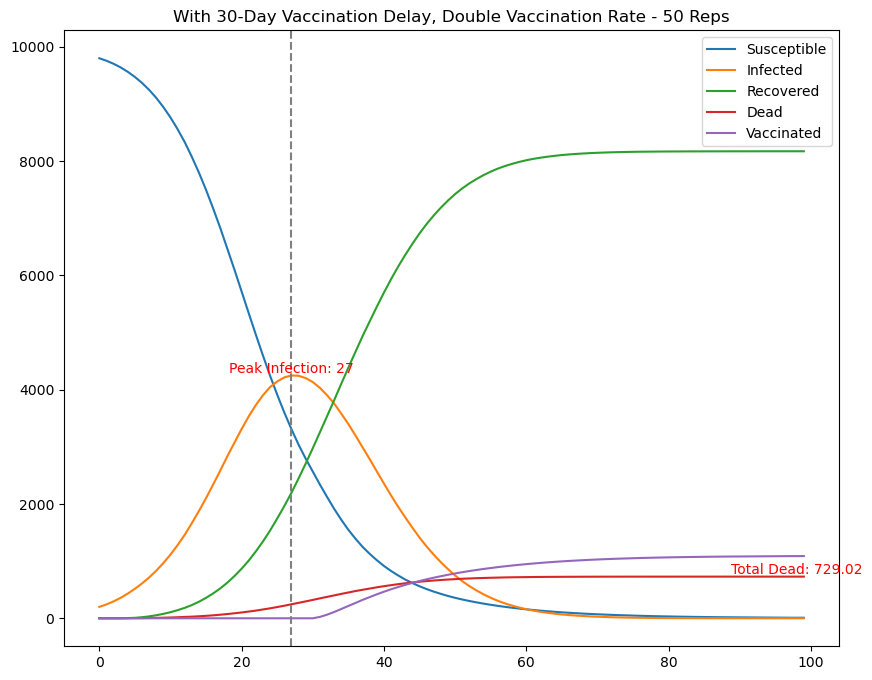

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(mean_data3_df['Total Susceptible'], label='Susceptible')
plt.plot(mean_data3_df['Total Infected'], label='Infected')
plt.plot(mean_data3_df['Total Recovered'], label='Recovered')
plt.plot(mean_data3_df['Total Dead'], label='Dead')
plt.plot(mean_data3_df['Total Vaccinated'], label='Vaccinated')
plt.axvline(mean_data3_df['Total Infected'].idxmax(), color='gray', linestyle='--')
plt.text(mean_data3_df['Total Infected'].idxmax(), mean_data3_df['Total Infected'].max(), f"Peak Infection: {mean_data3_df['Total Infected'].idxmax()}", color='red', fontsize=10, ha='center', va='bottom')
plt.text(mean_data3_df['Total Dead'].idxmax(), mean_data3_df['Total Dead'].max(), f"Total Dead: {mean_data3_df['Total Dead'].max()}", color='red', fontsize=10, ha='center', va='bottom')
plt.title('With 30-Day Vaccination Delay, Double Vaccination Rate - 50 Reps')
plt.legend()
plt.savefig("Model3.png")
plt.show()


## Calculating Difference in Means between 2 Scenarios

In [11]:
# Get 'Total Dead' at the last step for model2 (no vaccination delay)
sample_vals2 = mean_data2_df['Total Dead'].values
sample_mean_death2 = sample_vals2.max()
sample_mean_death2

571.26

In [12]:
# Get 'Total Dead' at the last step for model3 (with 30-day delay, but double vaccination rate)
sample_vals3 = mean_data3_df['Total Dead'].values
sample_mean_death3 = sample_vals3.max()
sample_mean_death3

729.02

In [13]:
# Calculate the difference in means between model2 and model3
diff_in_means = mean_data2_df['Total Dead'].mean() - mean_data3_df['Total Dead'].mean()

print(f"The mean difference in the Total number of deaths between the 2 scenarios is {diff_in_means}")

The mean difference in the Total number of deaths between the 2 scenarios is -106.2127999999999


## Calculating the Approximate Confidence Interval for Difference between 2 Means

In [15]:
# Calculate the sample variance and sample size for model2
sample_var_2 = mean_data2_df['Total Dead'].var()
n_2 = len(mean_data2_df['Total Dead'])

# Calculate the sample variance and sample size for model3
sample_var_3 = mean_data3_df['Total Dead'].var()
n_3 = len(mean_data3_df['Total Dead'])

# Calculate the estimated standard deviation of the difference in means
diff_estd_sample_sd = np.sqrt(sample_var_2/n_2 + sample_var_3/n_3)

# Calculate the approximate degrees of freedom
nu = (sample_var_2/n_2 + sample_var_3/n_3)**2 / ((sample_var_2/n_2)**2 / n_2+1 + (sample_var_3/n_3)**2 / n_3+1) - 2

# Calculate the t-score for the difference
t_score_for_diff = stats.t.ppf(0.975, nu)

# Calculate the confidence interval for the difference in means
CI_diff = (diff_in_means - t_score_for_diff*diff_estd_sample_sd , diff_in_means + t_score_for_diff*diff_estd_sample_sd)
CI_diff

print(f"The confidence interval at 0.05 alpha between the 2 scenarios is {CI_diff}")

The confidence interval at 0.05 alpha between the 2 scenarios is (-178.20563463781718, -34.219965362182606)


Since the lower and upper bounds of the confidence interval fall below zero, we can be reasonably sure that the mean of `Total Dead` for **Model 2** (no vaccination delays) is lower than that of **Model 3** (30-day delay, double vaccination rate).  Therefore, **Model 2** is better in terms of controlling the spread of disease, despite the increased vaccination rate for **Model 3**.